In [22]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt

from deep_logic import validate_network, prune_equal_fanin, collect_parameters
from deep_logic import fol

torch.manual_seed(0)
np.random.seed(0)

In [16]:
# XOR problem
x_train = torch.tensor([
    [0, 0],#, 1, 0, 0, 0, 0.4],
    [0, 1],#, 1, 0, 0, 0.4, 0.3],
    [1, 0],#, 0.7, 0, 0, 0.2, 0.1],
    [1, 1],#, 1, 0, 0, 0.3, 0.1],
], dtype=torch.float)
y_train = torch.tensor([0, 1, 1, 0], dtype=torch.float).unsqueeze(1)


x_test = torch.tensor([
    [0, 0.95],#, 0.4, 0, 0, 0.5, 0.8],
    [0, 0.9],#, 1, 0, 0, 1, 0.4],
    [0.05, 1],#, 1, 0, 0.8, 1, 0.8],
    [0.1, 0.8],#, 1, 0, 0, 1, 0.2],
    [0.45, 1],#, 0.1, 0.7, 0, 0, 0.8],
    [0.75, 0.2],#, 0.2, 0.6, 0, 1, 0.5],
    [0.75, 0.15],#, 0.8, 0, 0, 0, 0.8],
], dtype=torch.float)

In [17]:
layers = [
    torch.nn.Linear(x_train.size(1), 10, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 4, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1, bias=False),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
need_pruning = True
for epoch in range(1000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = torch.nn.functional.mse_loss(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.0001 * torch.norm(module.weight, 1)

    # backward pass
    loss.backward()
    optimizer.step()

    # compute accuracy
    if epoch % 100 == 0:
        y_pred_d = (y_pred > 0.5)
        accuracy = (y_pred_d.eq(y_train).sum(dim=1) == y_train.size(1)).sum().item() / y_train.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')

Epoch 0: train accuracy: 0.7500
Epoch 100: train accuracy: 1.0000
Epoch 200: train accuracy: 1.0000
Epoch 300: train accuracy: 1.0000
Epoch 400: train accuracy: 1.0000
Epoch 500: train accuracy: 1.0000
Epoch 600: train accuracy: 1.0000
Epoch 700: train accuracy: 1.0000
Epoch 800: train accuracy: 1.0000
Epoch 900: train accuracy: 1.0000


In [18]:
def reduced_model(xi, w, b):
    w2, b2 = [], []
    xin = xi.detach().numpy()
    # for i, (wi, bi) in enumerate(zip(np.copy(w), np.copy(b))):
    for i, wi in enumerate(np.copy(w)):
        # if i == 0:
        #     wi = wi[:, best_features_sorted]
        hi = np.matmul(wi, xin) #+ bi
        ai = np.max([np.zeros(len(hi),), hi], axis=0)
        wi2 = np.copy(wi)
        # bi2 = np.copy(bi)
        wi2[ai==0] = 0
        # bi2[ai==0] = 0
        w2.append(wi2)
        # b2.append(bi2)
        hi2 = np.matmul(wi2, xin) #+ bi2
        ai2 = np.max([np.zeros(len(hi2),), hi2], axis=0)
        assert np.all(ai == ai2)
        xin = ai2

    # for i, (wi, bi) in enumerate(zip(np.copy(w2), np.copy(b2))):
    for i, wi in enumerate(np.copy(w2)):
        if i == 0:
            wa = wi
            # ba = bi
        else:
            wa = np.matmul(wi, wa)
            # ba = np.matmul(wi, ba) + bi

    xin = xi
    output = np.matmul(wa, xin) #+ ba
    output = output > 0
    return output, wa#, ba

In [31]:
w, b = collect_parameters(model)
for xin in x_test:
    output, wa = reduced_model(xin, w, b)
    print(f'input: {xin} - output: {output}')
    wa_max = np.max(np.abs(wa))
    if wa_max > 0:
        wa2 = wa / wa_max
        wa2[wa2>0.5] = 1
        wa2[wa2<-0.5] = -1
        wa2[np.abs(wa2)!=1] = 0
        print(f'weights: {wa2}')

input: tensor([0.0000, 0.9500]) - output: tensor([True])
weights: [[-1.  1.]]
input: tensor([0.0000, 0.9000]) - output: tensor([True])
weights: [[-1.  1.]]
input: tensor([0.0500, 1.0000]) - output: tensor([True])
weights: [[-1.  1.]]
input: tensor([0.1000, 0.8000]) - output: tensor([True])
weights: [[-1.  1.]]
input: tensor([0.4500, 1.0000]) - output: tensor([True])
weights: [[-1.  1.]]
input: tensor([0.7500, 0.2000]) - output: tensor([True])
weights: [[ 1. -1.]]
input: tensor([0.7500, 0.1500]) - output: tensor([True])
weights: [[ 1. -1.]]


# Decision boundaries

In [108]:
def plot_decision_bundaries(model, x, h=0.1, cmap='BrBG', torch_model=True):
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    if torch_model:
        xx = torch.FloatTensor(np.c_[xx1.ravel(), xx2.ravel()])
        Z = model(xx).detach().numpy()
    else:
        xx = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict_proba(xx)[:, 1]
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return

## True decision boundaries

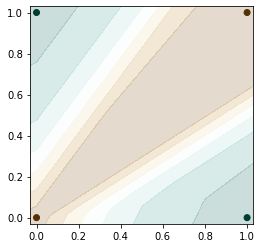

In [29]:
xnp = x_train.detach().numpy()
ynp = y_train.detach().numpy().ravel()
cmap='BrBG'

plt.figure(figsize=[4, 4])
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.show()

## Local decision boundaries

In [109]:
def plot_local_decision_bundaries(w, x, h=0.1, cmap='BrBG'):
    sigmoid = lambda z: 1/(1 + np.exp(-z))
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    xx = np.c_[xx1.ravel(), xx2.ravel()]
    Z = np.matmul(w, xx.T).ravel()
    probs = sigmoid(Z)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return

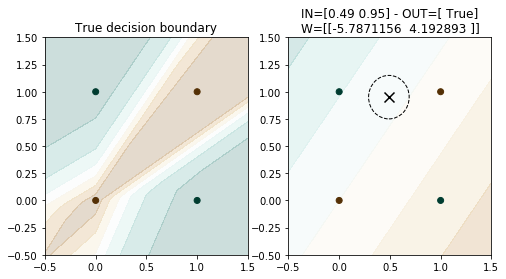

In [113]:
xin = torch.tensor([0.49, 0.95])
output, wa = reduced_model(xin, w, b)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}')
plot_local_decision_bundaries(wa, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

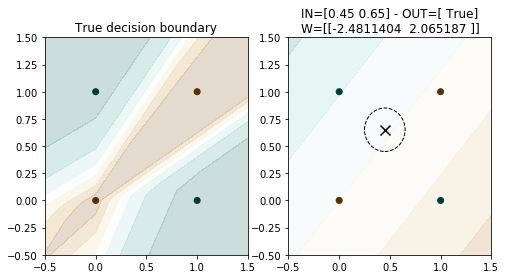

In [114]:
xin = torch.tensor([0.45, 0.65])
output, wa = reduced_model(xin, w, b)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}')
plot_local_decision_bundaries(wa, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

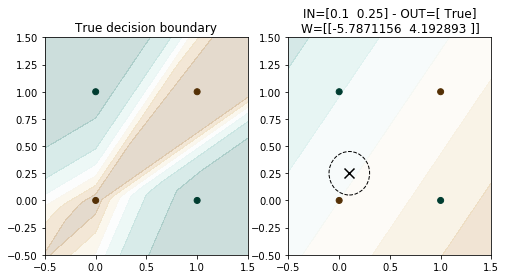

In [115]:
xin = torch.tensor([0.1, 0.25])
output, wa = reduced_model(xin, w, b)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}')
plot_local_decision_bundaries(wa, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

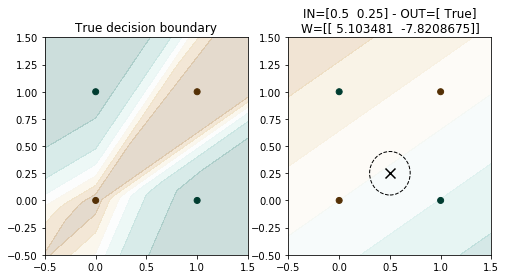

In [116]:
xin = torch.tensor([0.5, 0.25])
output, wa = reduced_model(xin, w, b)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}')
plot_local_decision_bundaries(wa, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()